# Model Preprocessing 

In [285]:
# importing libraries 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as stats
from sklearn.metrics import precision_score, recall_score, confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer

# model preprocessing libraries 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.compose import ColumnTransformer

In [286]:
# reading data for model preprocessing 
gamers_df = pd.read_csv('Data/preprocessed_data',index_col=0)
gamers_df

,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7,GADE,Game,Platform,...,Age,Work,Degree,Birthplace,Residence,Playstyle,GAD_T,Residence_ISO3,Birthplace_ISO3,anxiety
S. No.,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,1,0,0,Not difficult at all,Skyrim,"Console (PS, Xbox, ...)",...,25,Unemployed / between jobs,Bachelor (or equivalent),USA,USA,Singleplayer,1,USA,USA,minimal anxiety
2,1,2,2,2,0,1,0,Somewhat difficult,Other,PC,...,41,Unemployed / between jobs,Bachelor (or equivalent),USA,USA,Multiplayer - online - with strangers,8,USA,USA,mild anxiety
3,0,2,2,0,0,3,1,Not difficult at all,Other,PC,...,32,Employed,Bachelor (or equivalent),Germany,Germany,Singleplayer,8,DEU,DEU,mild anxiety
4,0,0,0,0,0,0,0,Not difficult at all,Other,PC,...,28,Employed,Bachelor (or equivalent),USA,USA,Multiplayer - online - with online acquaintanc...,0,USA,USA,minimal anxiety
5,2,1,2,2,2,3,2,Very difficult,Other,"Console (PS, Xbox, ...)",...,19,Employed,High school diploma (or equivalent),USA,South Korea,Multiplayer - online - with strangers,14,KOR,USA,moderate anxiety
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14246,1,0,0,1,0,1,1,Not difficult at all,Other,"Console (PS, Xbox, ...)",...,22,Student at college / university,Master (or equivalent),France,France,Multiplayer - online - with strangers,4,FRA,FRA,minimal anxiety
14247,3,3,3,3,2,3,3,Extremely difficult,League of Legends,PC,...,20,Student at college / university,High school diploma (or equivalent),USA,USA,Multiplayer - online - with strangers,20,USA,USA,severe anxiety
14248,0,0,0,0,0,0,0,Not difficult at all,Starcraft 2,PC,...,19,Student at college / university,High school diploma (or equivalent),Norway,Norway,Multiplayer - online - with real life friends,0,NOR,NOR,minimal anxiety


In [287]:
# looking at the different data types within the dataset 
gamers_df.dtypes

GAD1                 int64
GAD2                 int64
GAD3                 int64
GAD4                 int64
GAD5                 int64
GAD6                 int64
GAD7                 int64
GADE                object
Game                object
Platform            object
Hours              float64
earnings            object
whyplay             object
streams            float64
Gender              object
Age                  int64
Work                object
Degree              object
Birthplace          object
Residence           object
Playstyle           object
GAD_T                int64
Residence_ISO3      object
Birthplace_ISO3     object
anxiety             object
dtype: object

In [288]:
gamers_df.isna().sum()

GAD1                 0
GAD2                 0
GAD3                 0
GAD4                 0
GAD5                 0
GAD6                 0
GAD7                 0
GADE               590
Game                 0
Platform             0
Hours               22
earnings             0
whyplay              0
streams             81
Gender               0
Age                  0
Work                34
Degree               0
Birthplace           0
Residence            0
Playstyle            0
GAD_T                0
Residence_ISO3      88
Birthplace_ISO3     93
anxiety              0
dtype: int64

### Data Preprocessing Workflow 

From our earlier EDA work, we identified several different strategies for dealing with NaN values in our dataset. 
- `GADE` NaN values should be imputed with "Did not answer"
- `Hours` NaN values should be imputed using the `IterativeImputer` class
- `streams` NaN values should be imputed with 0 
- `Work` NaN values should be imputed using the `IterativeImputer` class
- `Residence_ISO3` and `Birthplace_ISO3` NaN values should be imputed with 'AAA' to reflect 'Unknown' values in their corresponding columns. 

### Data Preprocessing Pipelines 

**Why pipelines?**

In [297]:
# pipeline to replace NaNs in 'GADE' and 'Work' columns with 'Did not answer'
survey_pipeline = Pipeline([('obj_imputer', SimpleImputer(strategy='constant',fill_value='Did not answer'))])

# pipeline to replace NaNs in 'Hours and 'streams' with median value 
game_habits_pipeline = Pipeline([('numimputer', IterativeImputer(initial_strategy='median',random_state=42))])

In [299]:
survey_pipeline

Pipeline(steps=[('obj_imputer',
                 SimpleImputer(fill_value='Did not answer',
                               strategy='constant'))])

## Building a Baseline Model 

Before we ...

In [290]:
# splitting our dataset to predictor and target variables
X = gamers_df.drop(columns = ['anxiety','GAD_T','Birthplace_ISO3','Residence_ISO3'])
y = gamers_df['anxiety']

In [291]:
# viewing the distribution of class values 
y.value_counts(normalize=True)

minimal anxiety     0.555067
mild anxiety        0.271355
moderate anxiety    0.119506
severe anxiety      0.054072
Name: anxiety, dtype: float64

In [292]:
# label encoding our target variable 
lab_enc = LabelEncoder()
y = lab_enc.fit_transform(y)

In [293]:
# train-test splitting our data before imputation 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,random_state=42)

In [294]:
# looking at the NaNs in training set 
X_train.isna().sum()

GAD1            0
GAD2            0
GAD3            0
GAD4            0
GAD5            0
GAD6            0
GAD7            0
GADE          446
Game            0
Platform        0
Hours          19
earnings        0
whyplay         0
streams        67
Gender          0
Age             0
Work           28
Degree          0
Birthplace      0
Residence       0
Playstyle       0
dtype: int64

In [295]:
# writing a ColumnTransformer object with our imputation pipelines 
ct = ColumnTransformer(
    [("obj_imputer", survey_pipeline, ['GADE','Work']), 
     ("numimputer", game_habits_pipeline, ['Hours','streams'])])

In [283]:
ct.fit_transform(X_train)

array([['Not difficult at all', 'Student at school', 10.0, 50.0],
       ['Not difficult at all', 'Student at college / university', 20.0,
        40.0],
       ['Not difficult at all', 'Student at college / university', 10.0,
        10.0],
       ...,
       ['Not difficult at all', 'Unemployed / between jobs', 30.0, 15.0],
       ['Not difficult at all', 'Employed', 20.0, 2.0],
       ['Did not answer', 'Employed', 30.0, 10.0]], dtype=object)

In [219]:
# replacing NaN values in GADE with 'Did not answer'
X_train['GADE'].fillna('Did not answer',inplace=True)

# viewing new distribution of values in training set 
X_train['GADE'].value_counts()

Not difficult at all    4183
Somewhat difficult      3466
Very difficult           678
Did not answer           446
Extremely difficult      270
Name: GADE, dtype: int64

In [220]:
# replacing NaN values in Residence_ISO3 with 'AAA'
X_train['Residence_ISO3'].fillna('AAA',inplace=True)

In [221]:
# replacing NaN values in Birthplace_ISO3 with 'AAA'
X_train['Birthplace_ISO3'].fillna('AAA',inplace=True)

In [222]:
# viewing the distribution of values, including NaN for 'Work'
X_train['Work'].value_counts(dropna=False)

Student at college / university    4788
Employed                           1843
Student at school                  1455
Unemployed / between jobs           929
NaN                                  28
Name: Work, dtype: int64

In [223]:
# replacing 'Work' records where NaN appears with 'Did not answer'
X_train['Work'].fillna('Did not answer',inplace=True)

#### Iterative Imputation of `Hours` and `streams`

In [224]:
# viewing which values still need to be imputed 
X_train.isna().sum()

GAD1                0
GAD2                0
GAD3                0
GAD4                0
GAD5                0
GAD6                0
GAD7                0
GADE                0
Game                0
Platform            0
Hours              19
earnings            0
whyplay             0
streams            67
Gender              0
Age                 0
Work                0
Degree              0
Birthplace          0
Residence           0
Playstyle           0
Residence_ISO3      0
Birthplace_ISO3     0
dtype: int64

In [225]:
# instantiating IterativeImputer to calculate 
iter_impute = IterativeImputer(initial_strategy='median',random_state=42)

# fitting IterativeImputer on training set then applying transformation 
# subsetting the columns to iteratively impute on 
X_train[['Hours','streams']] = iter_impute.fit_transform(X_train[['Hours','streams']])

Now that we've cleaned up the training set, time to apply the same transformations on the test set

In [226]:
X_test.isna().sum()

GAD1                 0
GAD2                 0
GAD3                 0
GAD4                 0
GAD5                 0
GAD6                 0
GAD7                 0
GADE               144
Game                 0
Platform             0
Hours                3
earnings             0
whyplay              0
streams             14
Gender               0
Age                  0
Work                 6
Degree               0
Birthplace           0
Residence            0
Playstyle            0
Residence_ISO3      18
Birthplace_ISO3     23
dtype: int64

In [227]:
# replacing NaN values in GADE with 'Did not answer'
X_test['GADE'].fillna('Did not answer',inplace=True)

# viewing new distribution of values in training set 
X_test['GADE'].value_counts()

Not difficult at all    1397
Somewhat difficult      1153
Very difficult           239
Did not answer           144
Extremely difficult       82
Name: GADE, dtype: int64

In [228]:
# replacing NaN values in Residence_ISO3 with 'AAA'
X_test['Residence_ISO3'].fillna('AAA',inplace=True)

In [229]:
# replacing NaN values in Residence_ISO3 with 'AAA'
X_test['Birthplace_ISO3'].fillna('AAA',inplace=True)

In [230]:
X_test['Work'].fillna('Did not answer',inplace=True)

In [231]:
X_test[['Hours','streams']] = iter_impute.transform(X_test[['Hours','streams']])

### Baseline Dummy Classifier 

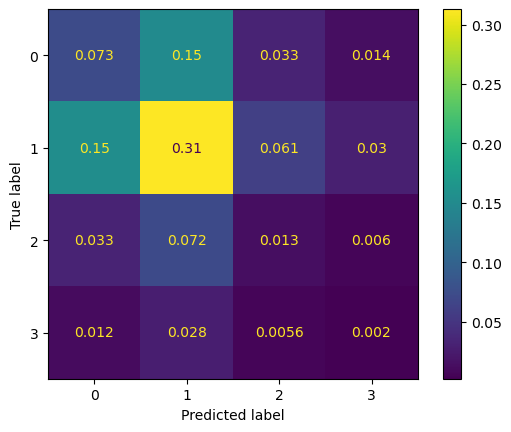

In [232]:
# instantiating Dummy Classifier 
dummy_clf = DummyClassifier(strategy='stratified',random_state=42)

# fitting DummyClassifier to training set 
dummy_clf.fit(X_train, y_train)

# predicting values on test set with DummyClassifier 
base_y_pred = dummy_clf.predict(X_test)

# creating confusion matrix between y_test and y_pred 
ConfusionMatrixDisplay.from_predictions(y_test,base_y_pred,normalize='all')

In [233]:
# classification report for baseline DummyClassifier 
print(classification_report(y_test,base_y_pred, target_names=target_labels))

                  precision    recall  f1-score   support

 minimal anxiety       0.27      0.27      0.27       817
    mild anxiety       0.55      0.56      0.56      1683
moderate anxiety       0.11      0.10      0.11       373
  severe anxiety       0.04      0.04      0.04       142

        accuracy                           0.40      3015
       macro avg       0.24      0.24      0.24      3015
    weighted avg       0.40      0.40      0.40      3015



### Feature Engineering Pipelines 

In [241]:
gamers_df.select_dtypes('object')

,GADE,Game,Platform,earnings,whyplay,Gender,Work,Degree,Birthplace,Residence,Playstyle,Residence_ISO3,Birthplace_ISO3,anxiety
S. No.,,,,,,,,,,,,,,
1,Not difficult at all,Skyrim,"Console (PS, Xbox, ...)",I play for fun,having fun,Male,Unemployed / between jobs,Bachelor (or equivalent),USA,USA,Singleplayer,USA,USA,minimal anxiety
2,Somewhat difficult,Other,PC,I play for fun,having fun,Male,Unemployed / between jobs,Bachelor (or equivalent),USA,USA,Multiplayer - online - with strangers,USA,USA,mild anxiety
3,Not difficult at all,Other,PC,I play for fun,having fun,Female,Employed,Bachelor (or equivalent),Germany,Germany,Singleplayer,DEU,DEU,mild anxiety
4,Not difficult at all,Other,PC,I play for fun,improving,Male,Employed,Bachelor (or equivalent),USA,USA,Multiplayer - online - with online acquaintanc...,USA,USA,minimal anxiety
5,Very difficult,Other,"Console (PS, Xbox, ...)",I play for fun,having fun,Male,Employed,High school diploma (or equivalent),USA,South Korea,Multiplayer - online - with strangers,KOR,USA,moderate anxiety
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14246,Not difficult at all,Other,"Console (PS, Xbox, ...)",I play for fun,improving,Male,Student at college / university,Master (or equivalent),France,France,Multiplayer - online - with strangers,FRA,FRA,minimal anxiety
14247,Extremely difficult,League of Legends,PC,I play for fun,winning,Female,Student at college / university,High school diploma (or equivalent),USA,USA,Multiplayer - online - with strangers,USA,USA,severe anxiety
14248,Not difficult at all,Starcraft 2,PC,I play for fun,having fun,Male,Student at college / university,High school diploma (or equivalent),Norway,Norway,Multiplayer - online - with real life friends,NOR,NOR,minimal anxiety


In [236]:
gamers_df.select_dtypes('int64','float64')

,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7,Age,GAD_T
S. No.,,,,,,,,,
1,0,0,0,0,1,0,0,25,1
2,1,2,2,2,0,1,0,41,8
3,0,2,2,0,0,3,1,32,8
4,0,0,0,0,0,0,0,28,0
5,2,1,2,2,2,3,2,19,14
...,...,...,...,...,...,...,...,...,...
14246,1,0,0,1,0,1,1,22,4
14247,3,3,3,3,2,3,3,20,20
14248,0,0,0,0,0,0,0,19,0


## Model I | Logistic Regression

In [244]:
# feature selection 
non_predict_cols = ['anxiety','Residence_ISO3','Birthplace_ISO3','GAD_T']
X_1 = gamers_df.drop(columns=non_predict_cols)
y_1 = gamers_df['anxiety']

In [249]:
# label encoding our target variable 
y_1 = lab_enc.fit_transform(y_1)

In [250]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X_1, y_1, test_size = 0.25,random_state=42)

In [251]:
X1_train.isna().sum()

GAD1            0
GAD2            0
GAD3            0
GAD4            0
GAD5            0
GAD6            0
GAD7            0
GADE          446
Game            0
Platform        0
Hours          19
earnings        0
whyplay         0
streams        67
Gender          0
Age             0
Work           28
Degree          0
Birthplace      0
Residence       0
Playstyle       0
dtype: int64